C:/Users/mccoo/OneDrive/mcook/data\hisdac_us\BUPR
['C:/Users/mccoo/OneDrive/mcook/data\\hisdac_us\\BUPR\\BUPR_2000.tif', 'C:/Users/mccoo/OneDrive/mcook/data\\hisdac_us\\BUPR\\BUPR_2005.tif', 'C:/Users/mccoo/OneDrive/mcook/data\\hisdac_us\\BUPR\\BUPR_2010.tif', 'C:/Users/mccoo/OneDrive/mcook/data\\hisdac_us\\BUPR\\BUPR_2015.tif']
count    1.502800e+04
mean             -inf
std               NaN
min              -inf
25%      2.167317e+00
50%      2.768638e+00
75%      3.380211e+00
max      6.013952e+00
Name: LOG_ACRES, dtype: float64
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 15028 entries, 0 to 15027
Data columns (total 90 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   X                          15028 non-null  int64   
 1   INCIDENT_ID                15028 non-null  object  
 2   INCIDENT_NUMBER            15028 non-null  object  
 3   INCIDENT_NAME              15028 non-null  object  
 4

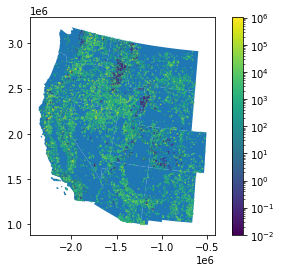

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Imports successful ...


In [47]:
# Modules
import os, glob
import pandas as pd
import geopandas as gpd
import numpy as np
import rasterstats as rs
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import geoplot as gplt
import warnings
warnings.filterwarnings('ignore')

# Directories
maindir = "C:/Users/mccoo/OneDrive/mcook/"
buprdir = os.path.join(maindir, 'data', 'hisdac_us', 'BUPR')
print(buprdir)
# BUPR Rasters
rasters = glob.glob(buprdir+"/*.tif", recursive=True)
print(rasters)

# Read in the spatial ICS-209-PLUS
path = os.path.join(
    maindir, 'ics209', 'data', 
    'ics209plus_wf_incidents_west_1999to2020.gpkg')
ics = gpd.read_file(path, driver="GPKG")
print(ics.info())

# remove records with 0 burned acres
zeros = ics[(ics['FINAL_ACRES']==0)] # save for later
nz = ics[(ics['FINAL_ACRES']!=0)]

# Read in state boundaries, subset to western states
path = os.path.join(
    maindir, 'data', 'boundaries', 'political', 
    'TIGER', 'tl_2019_west_state_albers.gpkg')
states = gpd.read_file(path, driver="GPKG")

# Simple map
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
f, ax = plt.subplots(1)
states.plot(ax=ax,aspect=1)
# ics.plot(ax=ax,column='LOG_ACRES',cmap=None,aspect=1,markersize=0.2)
ics.plot(
    ax=ax,column="FINAL_ACRES",legend=True, markersize=0.2, aspect=1,
    norm=matplotlib.colors.LogNorm()) 
plt.show()
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Imports successful ...")

In [48]:
# Generate a buffered data frame based on fire size
# Get the area in M2
ics['FINAL_M2'] = ics['FINAL_KM2']*1e+6
# Calculate the radius in M
ics['RADII'] = (ics['FINAL_M2']/3.14)**(1/2)
print(ics['FINAL_M2'].head(3), ics['RADII'].head(4))
# Ensure that 'RADII' has a minimum buffer size
ics = ics.assign(RADII = [175.0 if RADII < 175 else RADII for RADII in ics['RADII']])
print(ics['RADII'].describe()) 
# Buffer for each row by 'RADII'...
def buffer(row):
     return row.geometry.buffer(row.RADII)
# copy of the dataframe
buffered = ics.copy()
# apply the function
buffered['geometry'] = buffered.apply(buffer, axis=1)
print(buffered.head(3))
print(type(buffered))

0    2023430.0
1    1416401.0
2    2428116.0
Name: FINAL_M2, dtype: float64 0     802.748067
1     671.627219
2     879.366448
3    2662.414138
Name: RADII, dtype: float64
count    15028.000000
mean      1576.033357
std       2223.387492
min        175.000000
25%        432.293064
50%        867.933566
75%       1758.732897
max      36481.309608
Name: RADII, dtype: float64
     X                    INCIDENT_ID INCIDENT_NUMBER INCIDENT_NAME  \
0  223       1999_ID-BOD-F315_C RANCH     ID-BOD-F315       C RANCH   
1  224  1999_ID-BOD-F321_I-84 M.P. 78     ID-BOD-F321  I-84 M.P. 78   
2  225    1999_ID-BOD-F325_BLACK MESA     ID-BOD-F325    BLACK MESA   

  INCTYP_ABBREVIATION  FINAL_ACRES CAUSE COMPLEX DISCOVERY_DATE  \
0                  WF        500.0     H   False     1999-07-16   
1                  WF        350.0     H   False     1999-07-18   
2                  WF        600.0     H   False     1999-07-23   

   DISCOVERY_DOY  ...                 NA_L3NAME  NA_L2CODE     NA_L2NA

In [49]:
# Define zonal statistics function
def get_zonal_stats(vector, raster, stats):
    # Run zonal statistics, store result in geopandas dataframe
    result = rs.zonal_stats(vector, raster, stats=stats, geojson_out=True)
    return gpd.GeoDataFrame.from_features(result)

# Get the years for filtering the geodataframe
bupr_years = [int(os.path.basename(r)[5:9]) for r in rasters]
print(bupr_years)

ics_years = list(buffered['START_YEAR'].unique())
for i in range(0, len(ics_years)):
    ics_years[i] = int(ics_years[i])
print("min fire year: "+str(min(ics_years)))
print("max fire year: "+str(max(ics_years)))

[2000, 2005, 2010, 2015]
min fire year: 1999
max fire year: 2020


In [50]:
# Add an attribute to specify which BUPR semi-decade should be used
def f(row):
    if row['START_YEAR'] >= 1999 and row['START_YEAR'] < 2005:
        val = 2000
    elif row['START_YEAR'] >= 2005 and row['START_YEAR'] < 2010:
        val = 2005
    elif row['START_YEAR'] >= 2010 and row['START_YEAR'] < 2015:
        val = 2010
    else:
        val = 2015
    return val

# apply the function rowwise
buffered['BUPR_YEAR'] = buffered.apply(f, axis=1)
print(buffered['BUPR_YEAR'].head(5))
print(list(buffered['BUPR_YEAR'].unique()))

0    2000
1    2000
2    2000
3    2000
4    2000
Name: BUPR_YEAR, dtype: int64
[2000, 2005, 2010, 2015]


In [51]:
# Now, perform zonal statistics for each semi-decade
bupr_sums = [] #Empty list for results    
for yr in bupr_years:
    bupr = os.path.join(buprdir,'BUPR_'+str(yr)+'.tif')
    print(bupr)
    subset = buffered[(buffered['BUPR_YEAR']==yr)].set_geometry('geometry')
    print(type(subset))
    print(subset.geometry.name)
    print(list(subset['START_YEAR'].unique()))
    zs = get_zonal_stats(subset, bupr, stats='max median sum percentile_10 percentile_90')
    zs = zs.rename(
        columns={
            'max': 'BUPR_MAX', 
            'median': 'BUPR_MEDIAN', 
            'sum': 'BUPR_SUM',
            'percentile_10': 'pct10',
            'percentile_90': 'pct90'
        })
    bupr_sums.append(zs)
print(len(bupr_sums))

C:/Users/mccoo/OneDrive/mcook/data\hisdac_us\BUPR\BUPR_2000.tif
<class 'geopandas.geodataframe.GeoDataFrame'>
geometry
[1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0]
C:/Users/mccoo/OneDrive/mcook/data\hisdac_us\BUPR\BUPR_2005.tif
<class 'geopandas.geodataframe.GeoDataFrame'>
geometry
[2005.0, 2006.0, 2007.0, 2008.0, 2009.0]
C:/Users/mccoo/OneDrive/mcook/data\hisdac_us\BUPR\BUPR_2010.tif
<class 'geopandas.geodataframe.GeoDataFrame'>
geometry
[2010.0, 2011.0, 2012.0, 2013.0, 2014.0]
C:/Users/mccoo/OneDrive/mcook/data\hisdac_us\BUPR\BUPR_2015.tif
<class 'geopandas.geodataframe.GeoDataFrame'>
geometry
[2015.0, 2016.0, 2017.0, 2018.0, 2019.0, 2020.0]
4


In [52]:
# Merge results into one dataframe
# Combine the data frames
print("Merging data frames ...")
gdf = pd.concat(bupr_sums)
print(type(gdf))
print(gdf.info())

Merging data frames ...
<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 15028 entries, 0 to 4357
Data columns (total 98 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   geometry                   15028 non-null  geometry
 1   BUPR_YEAR                  15028 non-null  int64   
 2   CAUSE                      15028 non-null  object  
 3   COMPLEX                    15028 non-null  object  
 4   DISCOVERY_DATE             15023 non-null  object  
 5   DISCOVERY_DOY              15010 non-null  float64 
 6   EVACUATION_REPORTED        13895 non-null  object  
 7   EXPECTED_CONTAINMENT_DATE  6675 non-null   object  
 8   FATALITIES                 15028 non-null  float64 
 9   FINAL_ACRES                15028 non-null  float64 
 10  FINAL_KM2                  15028 non-null  float64 
 11  FINAL_M2                   15028 non-null  float64 
 12  FINAL_REPOR

In [53]:
# Write to file
print("Writing output file ...")
out_file = os.path.join(maindir, 'ics209', 'data', 'wf_incidents_west_bupr_summaries.gpkg')
gdf.to_file(out_file)

Writing output file ...
